In [5]:
import os
from glob import glob
from pathlib import Path

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from utils.plotting import plot_trajectory
from utils.processing import (
    normalize_angles_2pi,
    open_file,
    cut_jumps
    )


import seaborn as sns
from scipy import stats
#from scipy.ndimage import gaussian_filter1d
# from utils.processing import (
#     normalize_angles_2pi,
#     open_file,
#     cut_jumps,
#     save_preprocessed_data,
#     open_preprocessed_data,
#     )

In [13]:
def make_evrth():

    DATA_DIR = 'dataset'
    PREPROC_DATA_DIR = 'downsamp_preprocessed_dataset'

    # 1. open files
    dataset_names = sorted(glob(os.path.join(DATA_DIR, '*.txt')))
    datasets = {}
    for nam in dataset_names:
        k = Path(nam).stem
        v = open_file(nam, show=False)
        datasets[k] = v

    # 2. cut_jumps
    tr11 = datasets['Trace_1.1']  # TODO: params to config
    tr12 = datasets['Trace_1.2']  
    tr2 = datasets['Trace_2']
    tr5 = datasets['Trace_5']

    tr4 = cut_jumps(datasets['Trace_4'], xmax=40.4, xmin=-38.1, ymax=28.3, ymin=-47.6)
    tr3 = cut_jumps(datasets['Trace_3'], xmax=46.8, xmin=-48, ymax=46, ymin=-47)
    tr6 = cut_jumps(datasets['Trace_6'], xmax=45, xmin=-45, ymax=45, ymin=-42.2)
    tr7 = cut_jumps(datasets['Trace_7'], xmax=35, xmin=-38.7, ymax=40, ymin=-32)
    tr91 = cut_jumps(datasets['Trace_9.1'], xmax=42.5, xmin=-43.7, ymax=42.5, ymin=-42.7)
    tr92 = cut_jumps(datasets['Trace_9.2'], xmax=36.3, xmin=-46.5, ymax=45.4, ymin=-47.3)

    dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
    dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

    dfs_dict = {}
    for k, val in zip(dfs_names, dfs):
        dfs_dict[k] = val

    # 3. rescale x and y coords to fit area size 
    # может добавить функцию rescale_coord в processing.py? TODO
    def rescale_coord(data, new_min, new_max):
        min_old_x, max_old_x = np.min(data), np.max(data)
        data_rescaled = ((data - min_old_x) / (max_old_x - min_old_x)) * (new_max - new_min) + new_min
        return data_rescaled

    AREA_SIZE = [-40, 40]
    rescaled_dfs_dict = {}
    for k, df in dfs_dict.items():
        df = df.dropna()
        rescaled_x = rescale_coord(df['x'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
        rescaled_y = rescale_coord(df['y'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
        df.loc[:, 'x'] = rescaled_x
        df.loc[:, 'y'] = rescaled_y

        rescaled_dfs_dict[k] = df

    # 4. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
    def divide_traj_by_nans(df, k, dt_threshold, traj_drop_threshold=5):
        # 1. Drop Nans
        df = df.dropna()
        # 2. Find if any time jumps
        dt_times = df['time'].diff().to_numpy()
        dt_times[0] = 0.
        div_idx = np.where(dt_times > dt_threshold)[0]
        div_idx = np.asarray(div_idx)

        # Divide by time jumps
        if len(div_idx) > 0:
            div_idx = np.concatenate([np.array([0]),
                                      div_idx,
                                      np.array([len(df)])])
            sub_trajectories = []
            start_i = div_idx[0]
            for end_i in div_idx[1:]:
                if end_i - start_i > traj_drop_threshold:
                    sub_df = df[start_i:end_i]
                    sub_trajectories.append(sub_df)
                start_i = end_i + 1

            return k, sub_trajectories
        else:
            return k, [df]

    DROP_THRESHOLD = 5
    dt_thresholds = {'tr11': 0.035, 'tr12': 0.035, 'tr2': 0.035, 'tr3': 0.135,  # TODO: to configs
                     'tr4': 0.035,  'tr5': 0.035, 'tr6': 0.035, 'tr7': 0.035,
                     'tr91': 0.035, 'tr92': 0.035}

    subtraj_dfs_dict = {}
    for k, df in rescaled_dfs_dict.items():
        k, df_subtraj= divide_traj_by_nans(df, k, dt_threshold=dt_thresholds[k],
                                           traj_drop_threshold=DROP_THRESHOLD)
        subtraj_dfs_dict[k] = df_subtraj  # list of dfs

    # 5. resample to required dt


    def resample_data_to_larger_timestep(df, original_dt, new_dt):
        from scipy.signal import resample

        num_original_points = df.shape[0]
        duration = num_original_points * original_dt
        num_new_points = int(duration / new_dt)

        resampled_dfnp = resample(df.to_numpy()[:, 1:], num_new_points, axis=0)
        new_time = np.linspace(df['time'].iloc[0], df['time'].iloc[-1], num_new_points)
        #added 3 down change
        #print(resampled_dfnp[:, 0])
        #print(resampled_dfnp)
        if len(resampled_dfnp) > 1:
            resampled_df = pd.DataFrame({'time': new_time,
                                         'x': resampled_dfnp[:, 0], 
                                         'y': resampled_dfnp[:, 1]})
        #added 2 down change
        else:
            resampled_df = pd.DataFrame(columns=['time','x','y'])
        return resampled_df

    # NOTE: We ignore that there are TWO most frequent dt-s: 0.033 and 0.034
    ORIGINAL_DT = {'tr11': 0.034, 'tr12': 0.034, 'tr2': 0.034, 'tr3': 0.134,  # TODO: to configs
                   'tr4': 0.034, 'tr5': 0.034, 
                   'tr6': 0.034, 'tr7': 0.034, 'tr91': 0.034, 'tr92': 0.034}


    resampled_subtraj_dfs_dict = {}
    for k, df in subtraj_dfs_dict.items():
        subtraj_list = []
        for sub_traj_df in df:
            resampled_sub_traj_df = resample_data_to_larger_timestep(sub_traj_df,
                                                                        ORIGINAL_DT[k],
                                                                        NEW_DT)
            #changed
            if len(resampled_sub_traj_df) > 1:
                subtraj_list.append(resampled_sub_traj_df)
        resampled_subtraj_dfs_dict[k] = subtraj_list


    # 6. add angles, delta_angles, step len, 
    def add_angles(df):
        dt = df['time'].diff()
        vvx = df['x'].diff() / dt 
        vvy = df['y'].diff() / dt 
        dt[0], vvx[0], vvy[0] = 0., 0., 0.

        Xx = np.arctan2(vvx, vvy)
        Nres = normalize_angles_2pi(Xx)
        ang = np.rad2deg(Nres) % 360
        df['angles'] = ang
        return df

    def add_delta_angles(df):
        dangles = df['angles'].diff()
        dangles[0] = 0.
        dangles_rad = np.deg2rad(dangles)
        normed_dangels_rad = normalize_angles_2pi(dangles_rad)
        df['delta_angle'] = np.rad2deg(normed_dangels_rad) % 360
        return df

    def add_step_length(df):
        dx = df['x'].diff()
        dy = df['y'].diff()
        dx[0], dy[0] = 0., 0.,
        step_lens = (dx**2 + dy**2)**0.5
        df['step_length'] = step_lens
        return df


    dfs_dict_with_angles = {}
    for k, df in resampled_subtraj_dfs_dict.items():
        subtraj_list = []
        for sub_traj_df in df:
            df_ang = add_angles(sub_traj_df)
            df_dt_ang = add_delta_angles(df_ang)
            df_step = add_step_length(df_dt_ang)
            subtraj_list.append(df_step)
        dfs_dict_with_angles[k] = subtraj_list

    # 7. sort be areas of open field
    #долго выполняется если рисовать все графики


    def sort_walls_area(tr, border_tr, wall_percent=0.1): 
        ylen = border_tr['ymax'] - border_tr['ymin'] 
        xlen = border_tr['xmax'] - border_tr['xmin'] 
        xl = border_tr['xmin'] + xlen * wall_percent
        xr = border_tr['xmax'] - xlen * wall_percent
        yd = border_tr['ymin'] + ylen * wall_percent
        yu = border_tr['ymax'] - ylen * wall_percent

        tr['near_wall'] = 0.
        for i in range(len(tr)):     
            if tr['x'].iloc[i] < xl:
                if tr['y'].iloc[i] > yu:
                    tr['near_wall'].iloc[i] = 40
                elif tr['y'].iloc[i] < yd:
                    tr['near_wall'].iloc[i] = 30
                else:
                    tr['near_wall'].iloc[i] = 4
            elif tr['x'].iloc[i] > xr:
                if tr['y'].iloc[i] > yu:
                    tr['near_wall'].iloc[i] = 10
                elif tr['y'].iloc[i] < yd:
                    tr['near_wall'].iloc[i] = 20
                else:
                    tr['near_wall'].iloc[i] = 2
            elif tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 1
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 3
        return tr

    def plot_wall_sorted_samples(df, plot_title):
        all_areas = [40, 30, 20, 10, 4, 3, 2, 1, 0]
        for a in all_areas:
            x = df.loc[df['near_wall'] == a]['x']
            y = df.loc[df['near_wall'] == a]['y']
            plt.scatter(x, y, s=1.5, label=str(a))
        plt.gca().set_aspect('equal')
        plt.title(plot_title)
        plt.legend(loc='center')
        plt.show()


    dfs_with_walls = {}
    bord40 =  {'xmin': -40,'xmax': 40,'ymin': -40,'ymax': 40}   

    for k, df in dfs_dict_with_angles.items():
        subtraj_list = []
        for sub_df in df:
            sub_df = sort_walls_area(sub_df, bord40, wall_perc)
            #plot_wall_sorted_samples(sub_df, k)
            subtraj_list.append(sub_df)
        dfs_with_walls[k] = subtraj_list

    # 8. merge dfs of each mouse
    #dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
    #the first row from each df is deleted because it has angle 0 and delta angle 0
    merg_resampled_dfs_dict = {}
    for k, df in dfs_with_walls.items():
        df = [df0.iloc[1:].reset_index() for df0 in df]
        merg_resampled_dfs_dict[k] = pd.concat(df)
        merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)
    for k,df in merg_resampled_dfs_dict.items():
        print(len(df))

    # 9.make 4 general dfs (for all mice) for angles +- parallel to the wall in areas 1 and 3, other angles 
    # in areas 1 and 3, +- parallel to the wall in areas 2 and 4, other angles in areas 2 and 4

    #make scatter plot of near wall delta angles with respect to angles

    #проверено, насколько уменьшилось количество точек по сравнению с вариантом где не вырезаны первые строки суб траектории
    #там 5704, тут 5547
    DfsStep13, DfsStep24 = {}, {}
    n=0
    for k, df in merg_resampled_dfs_dict.items():
        DfsStep13[k] = df.loc[(df['near_wall']==1) | (df['near_wall']==3)]
        DfsStep13[k] = DfsStep13[k].reset_index()
        DfsStep13[k] = DfsStep13[k].drop(['index'], axis=1) 
        n += len(DfsStep13[k])

        DfsStep24[k] = df.loc[(df['near_wall']==2) | (df['near_wall']==4)]
        DfsStep24[k] = DfsStep24[k].reset_index()
        DfsStep24[k] = DfsStep24[k].drop(['index'], axis=1)


    #we took approximately equal number of points from every mouse for par13 (dfs where mice are 
    #in areas 1 + 3 and their vectors are +- parallelto the wall or not parallel (regular angles)  
    par13 = []
    reg13 = []
    p13len = []
    r13len = []
    for k, df in DfsStep13.items():
        mask = ((df['angles']>=90-angInterval) & (df['angles']<=90+angInterval)) \
                                   | ((df['angles']>=270-angInterval) & (df['angles']<=270+angInterval))
        parallel_df = df.loc[mask]
        not_parallel_df = df[~mask]
        p13len.append(len(parallel_df))
        r13len.append(len(not_parallel_df))
        par13.append(parallel_df) 
        reg13.append(not_parallel_df)
    print(sorted(p13len), sorted(r13len))
    lp13 =round(np.percentile(p13len, 40))
    lr13 = round(np.percentile(r13len, 40))
    print(lp13,lr13)

    for i in range(len(par13)):
        if len(par13[i]) > lp13:
            par13[i] = par13[i].iloc[0:lp13]
    for i in range(len(reg13)):
        if len(reg13[i]) > lr13:
            reg13[i] = reg13[i].iloc[0:lr13]


    dfPar13 = pd.concat(par13)
    dfReg13 = pd.concat(reg13)

    plt.scatter(dfReg13['angles'], dfReg13['delta_angle'], s=1, color='bisque', label='not parall')
    plt.scatter(dfPar13['angles'], dfPar13['delta_angle'], s=1, color='darkred', label='parall')
    plt.axvline(90, c='black')
    plt.axvline(270, c='black')
    plt.legend()
    plt.title('How mouse change its angel wrt angle she is currently in')
    plt.xlabel('angle')
    plt.ylabel('delta angle')
    plt.show()


    #in areas 2 + 4  
    par24 = []
    reg24 = []
    p24len = []
    r24len = []
    for k, df in DfsStep24.items():
        mask = ((df['angles']>=90-angInterval) & (df['angles']<=90+angInterval)) \
                                   | ((df['angles']>=270-angInterval) & (df['angles']<=270+angInterval))
        mask = ((df['angles']>=360-angInterval) | (df['angles']<=angInterval)) \
                                | ((df['angles']>=180-angInterval) & (df['angles']<=180+angInterval))
        parallel_df = df.loc[mask]
        not_parallel_df = df[~mask]
        p24len.append(len(parallel_df))
        r24len.append(len(not_parallel_df))
        par24.append(parallel_df) 
        reg24.append(not_parallel_df)
    print(sorted(p24len), sorted(r24len))
    lp24 =round(np.percentile(p24len, 40))
    lr24 = round(np.percentile(r24len, 40))
    print(lp24,lr24)

    for i in range(len(par24)):
        if len(par24[i]) > lp24:
            par24[i] = par24[i].iloc[0:lp24]
    for i in range(len(reg24)):
        if len(reg24[i]) > lr24:
            reg24[i] = reg24[i].iloc[0:lr24]


    dfPar24 = pd.concat(par24)
    dfReg24 = pd.concat(reg24)

    plt.scatter(dfReg24['angles'], dfReg24['delta_angle'], s=1, color='aquamarine', label='not parall')
    plt.scatter(dfPar24['angles'], dfPar24['delta_angle'], s=1, color='indigo', label='parall')
    plt.axvline(90, c='black')
    plt.axvline(270, c='black')
    plt.legend()
    plt.title('How mouse change its angel wrt angle she is currently in')
    plt.xlabel('angle')
    plt.ylabel('delta angle')
    plt.show()

    # 10. make hists of near wall delta angle distributions near the wall. we consider 2 types of angles: angles that are
    #  +- parallel to the walls and others  
    wall_hist = {}
    fig, axes = plt.subplots(1, 4, figsize=(16, 3))
    names = ['par13', 'reg13', 'par24', 'reg24']
    for i, dat in enumerate([dfPar13, dfReg13, dfPar24, dfReg24]):
        freqs, binEdges, _ = axes[i].hist(dat['delta_angle'], bins=bins)
        if i ==0:
            print(f'Bin size is {binEdges[1] - binEdges[0]} (degrees)')
        for ang in [0, 90, 180, 360]:
            axes[i].axvline(ang, c='black', alpha=0.5)
        axes[i].set_title(f'delta angles for {names[i]}')

        bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
        wall_hist[names[i]] = [bin_mid, freqs]
    plt.show()

    #all together
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    u = 0
    for i, h in wall_hist.items():
        #axes[u]  = fig.add_subplot(2, 2, 1)
        axes[u].plot(h[0], h[1])
        axes[u].set_title(f'Delta angle distribution, {i} area, bins={bins}')
        u += 1
    plt.show()

    #all normalized
    def min_max_normalize(y):
        yn = (y - y.min()) / (y.max() - y.min())
        return yn

    for k, df in wall_hist.items():
        df[1] = min_max_normalize(df[1])
        plt.plot(df[0], df[1], label=k)
    plt.title(f'dAng distributions in near wall area, bins={bins}, dt={NEW_DT}, perc={wall_perc}, +-ang={angInterval}')
    plt.legend()
    plt.savefig("pict_parameters_deltaanddistr/nearwall_distr_bins_"+str(bins)+'_dt_'+str(NEW_DT)+'_perc_'+str(wall_perc)+'_+-ang_'+str(angInterval)+".png")
    plt.show()


    # all together
    # for i, dat in enumerate([dfPar13, dfReg13, dfPar24, dfReg24]):
    #     plt.hist(dat['delta_angle'], label=names[i], alpha=0.5, bins=bins)
    # for ang in [0, 90, 180, 360]:
    #     plt.axvline(ang, c='black', alpha=0.5)
    # plt.title('All delta angles together')
    # plt.legend()
    # plt.show()

    # 10. we took the same amount of point from every mouse from every type of area (center(area 0), near walls, corners)
    # to build averaged angle/delta angle distributions

    MaxLenDict = {}
    all_l = []
    for area in [1, 2, 3, 4]:
        for k, df in merg_resampled_dfs_dict.items():    
            all_l.append(len(df.loc[df["near_wall"] == area]))
    MaxLenDict['nearWalls'] = round(np.percentile(all_l, 40))

    all_l=[]
    for k, df in merg_resampled_dfs_dict.items():    
        all_l.append(len(df.loc[df["near_wall"] == 0]))
    MaxLenDict['0'] = round(np.percentile(all_l, 40))

    all_l=[]
    for area in [10, 20, 30, 40]:
        for k, df in merg_resampled_dfs_dict.items():    
            all_l.append(len(df.loc[df["near_wall"] == area]))
    MaxLenDict['corner'] = round(np.percentile(all_l, 40))

    print(MaxLenDict)

    def cut_into_dict(dfs_dict, area, max_len):
        cutted_df_dict = {}
        for k, df in dfs_dict.items():
            # print(k + ' ' + str(area))  # tmp
            cutted_df = df.loc[df['near_wall'] == area]
            # print(len(cutted_df))  # tmp
            cutted_df = cutted_df.iloc[:max_len]
            # print(len(cutted_df))  # tmp
            cutted_df_dict[k] = cutted_df

        return cutted_df_dict

    walls = [10, 20, 30, 40]
    near_corner_dict = {}
    for w in walls:
        near_corner_dict[w] = cut_into_dict(merg_resampled_dfs_dict, w, MaxLenDict['corner'])

    walls = [1, 2, 3, 4]  # TODO different max_len ???
    near_wall_dict = {}
    for w in walls:
        near_wall_dict[w] = cut_into_dict(merg_resampled_dfs_dict, w, MaxLenDict['nearWalls'])

    walls = [0]
    near_center_dict = {}
    for w in walls:
        near_center_dict[w] = cut_into_dict(merg_resampled_dfs_dict, w, MaxLenDict['0'])

    def merge_df(df_dict):
        delta_ang_list = []
        for k, dfdfdf in df_dict.items():
            for l, df in dfdfdf.items():
                delta_ang_list.append(df['delta_angle'])
            dfN = pd.concat(delta_ang_list)
            dfN = dfN.reset_index()
            dfN = dfN.drop(['index'], axis=1)
        return dfN

    #хз плохо ли что для распределений в разные типы зон берется разное количество точек. можно взять одинаковое
    #понятно что из полученных словарей (near_wall_dict и тд) легко построить распределение для каждой зоны

    #made df for every zone (corners, center, walls)
    aver_delta_angles = {}

    aver_corner = merge_df(near_corner_dict)
    print(f'For area corner df len={len(aver_corner)}')
    aver_delta_angles['corner'] = aver_corner

    aver_wall = merge_df(near_wall_dict)
    print(f'For area wall df len={len(aver_wall)}')
    aver_delta_angles['wall'] = aver_wall

    aver_center = merge_df(near_center_dict)
    print(f'For area center df len={len(aver_center)}')
    aver_delta_angles['center'] = aver_center

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    delta_ang_hist = {}

    freqs, binEdges, _ = axes[0].hist(aver_delta_angles['corner'], bins=bins)
    bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
    delta_ang_hist['corner']  = [bin_mid, freqs]
    axes[0].plot(bin_mid, freqs)
    axes[0].set_title(f'All mice, all corners [10, 20, 30, 40], bins={bins}')

    freqs, binEdges, _ = axes[1].hist(aver_delta_angles['wall'], bins=bins)
    bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
    delta_ang_hist['wall']  = [bin_mid, freqs]
    axes[1].plot(bin_mid, freqs)
    axes[1].set_title(f'All mice, all walls [1, 2, 3, 4], bins={bins}')

    freqs, binEdges, _ = axes[2].hist(aver_delta_angles['center'], bins=bins)
    bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
    delta_ang_hist['center']  = [bin_mid, freqs]
    axes[2].plot(bin_mid, freqs)
    axes[2].set_title(f'All mice, center [0], bins={bins}')

    plt.figure()
    for k, l in delta_ang_hist.items():
        l[1] = min_max_normalize(l[1])
        plt.plot(l[0], l[1], label=k)
    plt.title(f'dAng distributions in all areas, bins={bins}, dt={NEW_DT}, perc={wall_perc}, +-ang={angInterval}')
    plt.legend()
    plt.savefig("pict_parameters_deltaanddistr/all_areas_distr_bins_"+str(bins)+'_dt_'+str(NEW_DT)+'_perc_'+str(wall_perc)+'_+-ang_'+str(angInterval)+".png")
    plt.show()

    # # Save distributions
    # import pickle
    # with open(f'dec23_angWallsDistr_nbins_{bins}.pkl', 'wb') as fp:
    #     pickle.dump(delta_ang_hist, fp)



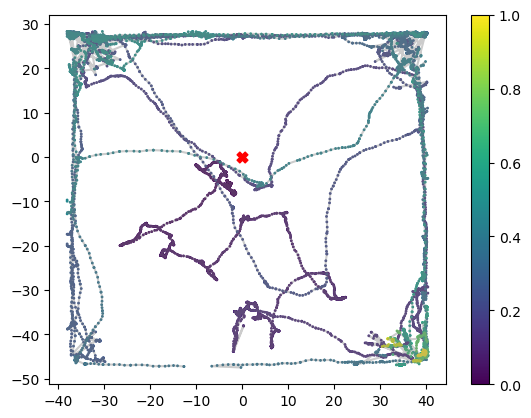

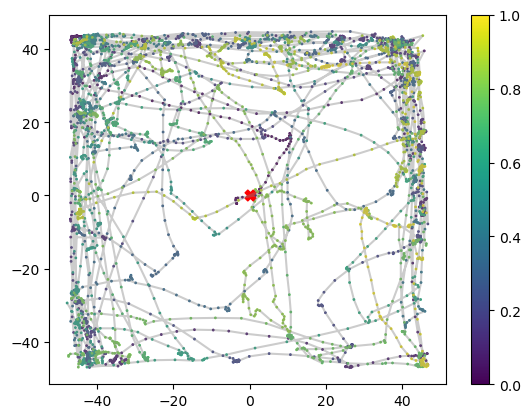

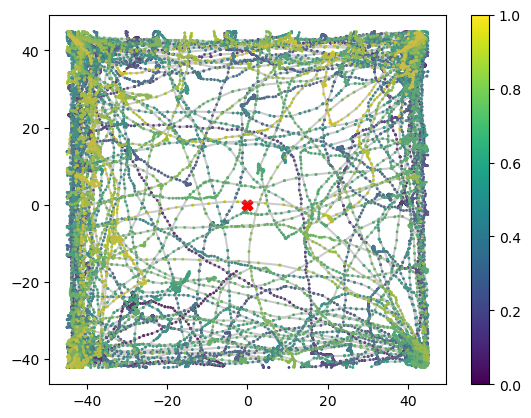

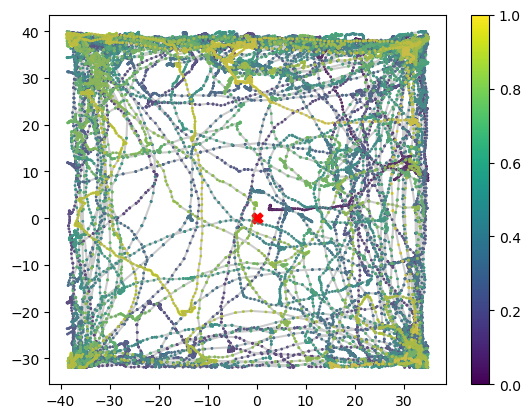

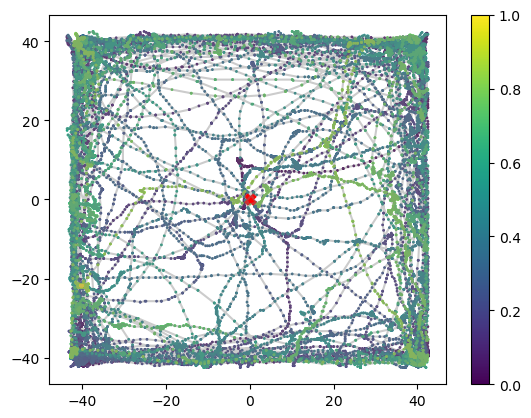

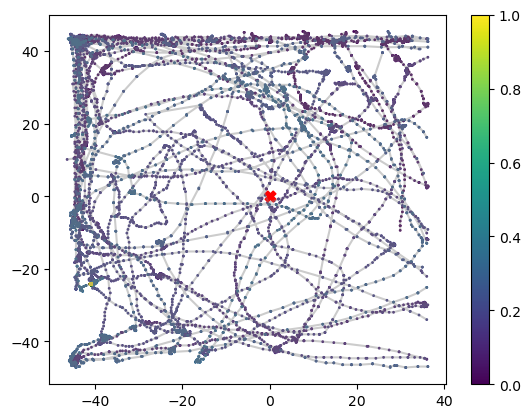

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22192\3214617994.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'x'] = rescaled_x
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22192\3214617994.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'y'] = rescaled_y
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22192\3214617994.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

3573
3565
3555
1216
462
1618
3038
2971
3393
2943
[57, 71, 174, 189, 219, 355, 420, 426, 435, 594] [26, 71, 129, 130, 201, 253, 374, 443, 490, 490]
207 173


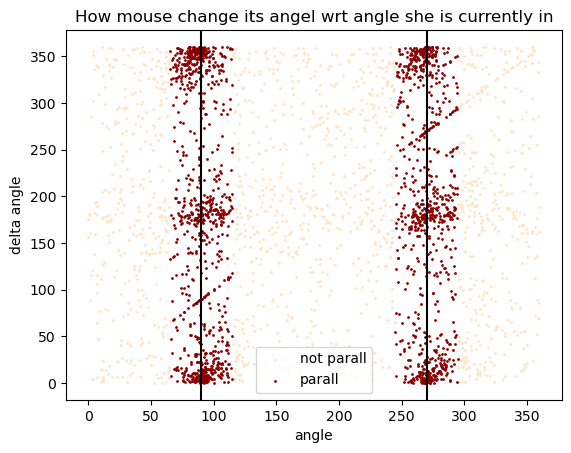

[71, 241, 243, 244, 301, 317, 418, 490, 498, 625] [21, 153, 179, 204, 234, 395, 450, 453, 968, 1627]
278 222


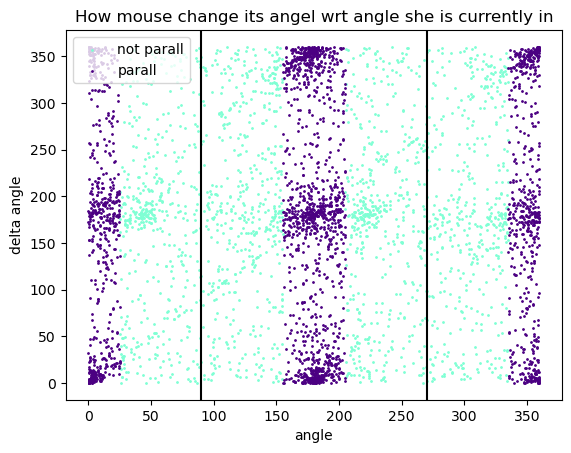

Bin size is 4.499162619126229 (degrees)


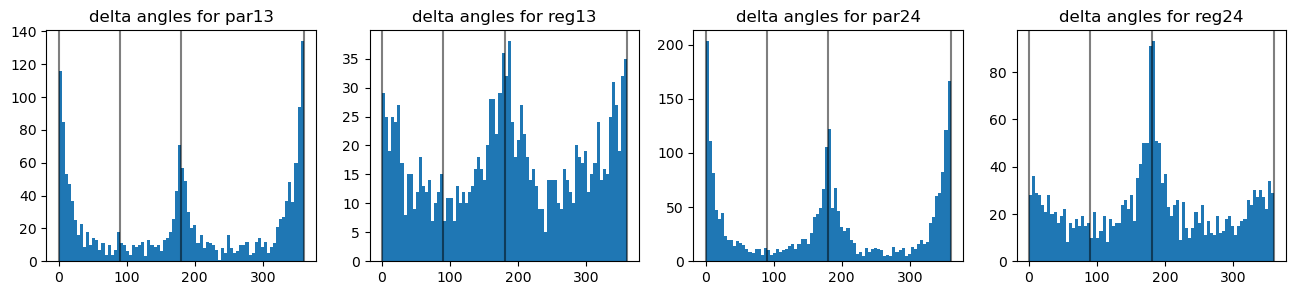

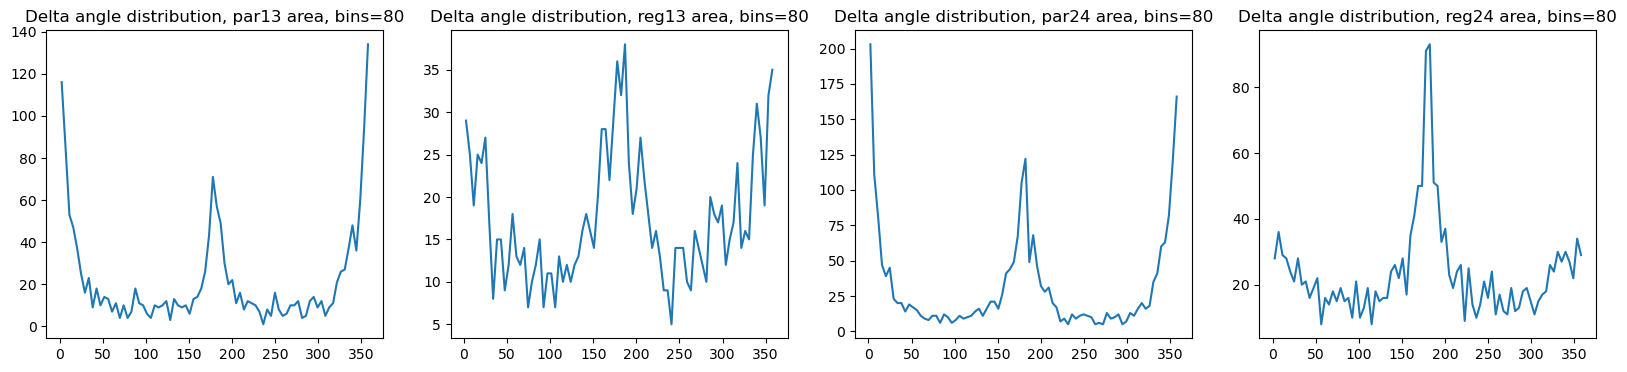

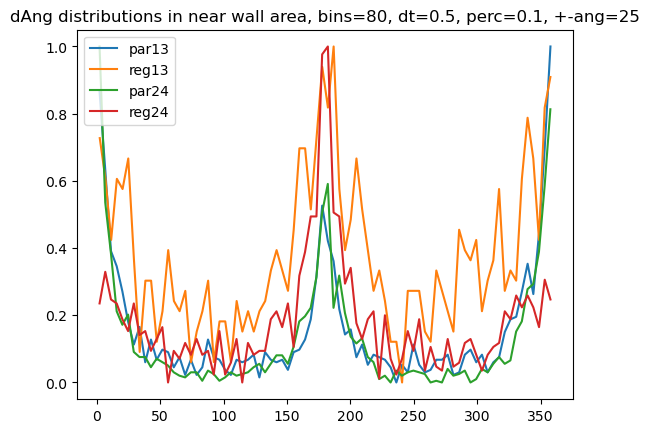

{'nearWalls': 215, '0': 395, 'corner': 119}
For area corner df len=3644
For area wall df len=6894
For area center df len=3477


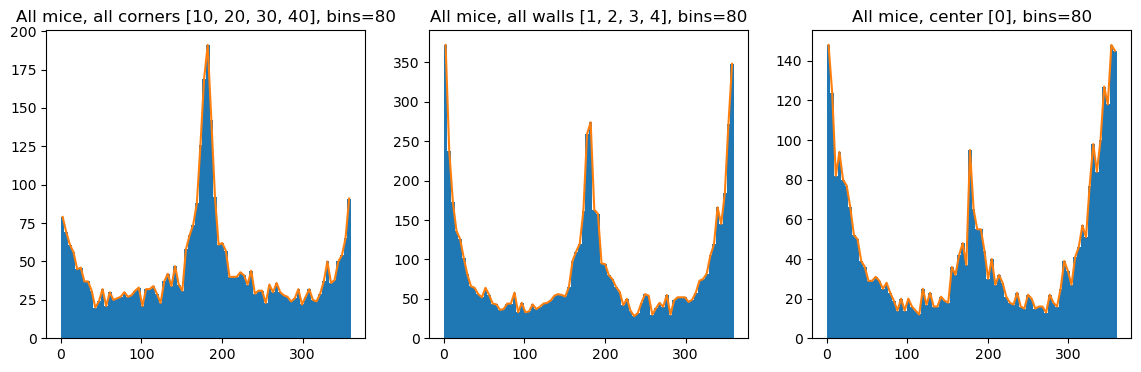

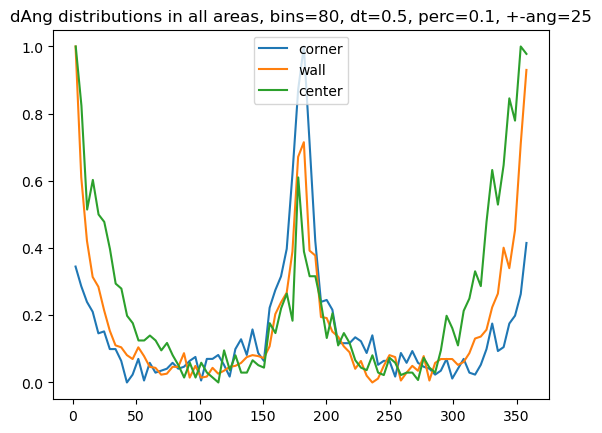

In [14]:
#parameter to change! time lag between neighboring points 
NEW_DT = 0.5
# parameter to change! how much of the length of the square field side we consider as the area close to the wall 
wall_perc=0.1
# parameter to change! If angle is in 90+-angInterval (as well as 270+-angInterval) we consider it as an angle 
#approximately parallel to the front wall
angInterval = 25
#parameter to change! number of bins for building averaged angle distributions
bins = 80

make_evrth()

### draft

In [ ]:
# # Save distributions
# import pickle
# with open(f'angWallsDistr_nbins_{bins}.pkl', 'wb') as fp:
#     pickle.dump(wall_hist, fp)
    

In [98]:
#норм ли будет усреднять углы с разным количествои точек?
MaxLenDict = {}
all_l = []
for area in [1, 2, 3, 4]:
    for k, df in merg_resampled_dfs_dict.items():    
        all_l.append(len(df.loc[df["near_wall"] == area]))
MaxLenDict['nearWalls'] = round(np.percentile(all_l, 40))

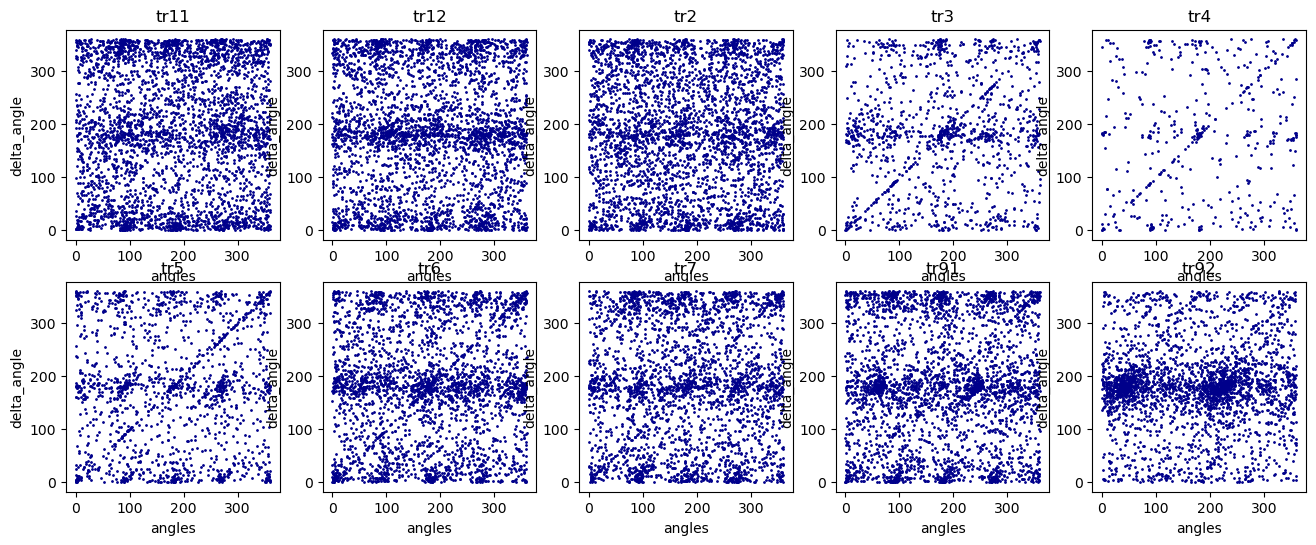

In [10]:
# In 9 all areas
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
j, i = 0, 0
for k in merg_resampled_dfs_dict:
    merg_resampled_dfs_dict[k].plot.scatter(x='angles',y='delta_angle', c='DarkBlue',s=1, ax=axes[j, i])
    axes[j, i].set_title(k)
    i += 1
    if i == 5:
        j = 1
        i = 0
plt.show()

In [15]:

#delete TODO (compare these results with old DeltaDirectionsDistributions01)
# m = 0
# for k, df in resampled_subtraj_dfs_dict.items():
#     n = 0
#     for sub_traj_df in df:
#         n += len(sub_traj_df)
#     m += n
#     print(k,n)
# print('all together', m)
# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# m = 0
# for k, df in resampled_subtraj_dfs_dict.items():
#     n = 0
#     for sub_traj_df in df:
#         n += len(sub_traj_df)
#     m += n
#     print(k,n)
# print('all together', m)

# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# #dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
# merg_resampled_dfs_dict = {}
# for k, df in resampled_subtraj_dfs_dict.items():
#     merg_resampled_dfs_dict[k] = pd.concat(df)
#     merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)
# print(merg_resampled_dfs_dict)
# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# #dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
# merg_resampled_dfs_dict = {}
# for k, df in resampled_subtraj_dfs_dict.items():
#     merg_resampled_dfs_dict[k] = pd.concat(df)
#     merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)
# print(merg_resampled_dfs_dict)

#delete TODO (compare these results with old DeltaDirectionsDistributions01)
# for k, df in merg_resampled_dfs_dict.items():
#     plot_wall_sorted_samples(df,k)
# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# for k, df in merg_resampled_dfs_dict.items():
#     plot_wall_sorted_samples(df,k)
#delete TODO (compare these results with old DeltaDirectionsDistributions01)
# for k, df in merg_resampled_dfs_dict.items():
#     print(k, 'all', len(df))
#     print(k,'1+3', len(df.loc[(df['near_wall']==1) | (df['near_wall']==3)]))
#     print(k,'ratio', (len(df.loc[(df['near_wall']==1) | (df['near_wall']==3)]) / len(df)))
# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# for k, df in merg_resampled_dfs_dict.items():
#     print(k, 'all', len(df))
#     print(k,'1+3', len(df.loc[(df['near_wall']==1) | (df['near_wall']==3)]))
#     print(k,'ratio', (len(df.loc[(df['near_wall']==1) | (df['near_wall']==3)]) / len(df)))
# for k, df in dfs_dict_with_angles.items():
#     subtraj_list = []
#     for sub_df in df:
#         sub_df = sort_walls_area(sub_df, bord40)
#         #plot_wall_sorted_samples(sub_df, k)
#         subtraj_list.append(sub_df)
#     dfs_with_walls[k] = subtraj_list


In [17]:
# #delete TODO
# #show to Katya Compare
# #ок, будем считать что это +- похоже на старые резы
# for k, df in merg_resampled_dfs_dict.items():
#     plt.figure()
#     plt.title(k)
#     plt.plot(df.iloc[:50]['time'],df.iloc[:50]['angles'])



In [16]:
# delete TODO
# make the same 13 and 24 from merged df
# altDfsStep13, altDfsStep24 = {}, {}
# for i, df in merg_resampled_dfs_dict.items():
#     altDfsStep13[i] = df.loc[(df['near_wall']==1) | (df['near_wall']==3)]
#     altDfsStep13[i] = altDfsStep13[i].reset_index()
#     altDfsStep13[i] = altDfsStep13[i].drop(['index'], axis=1)
#     altDfsStep24[i] = df.loc[(df['near_wall']==2) | (df['near_wall']==4)]
#     altDfsStep24[i] = altDfsStep24[i].reset_index()
#     altDfsStep24[i] = altDfsStep24[i].drop(['index'], axis=1)

# delete TODO
# for k, df in altDfsStep13.items():
#     print(k, len(df))

In [18]:
# delete TODO
# for k, df in altDfsStep13.items():
#     print(k, len(df))

In [ ]:
#merge delete
merg_resampled_dfs_dict = {}
for k, df in dfs_with_walls.items():
    #df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_resampled_dfs_dict[k] = pd.concat(df)
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)
for k,df in merg_resampled_dfs_dict.items():
    print(len(df))

In [ ]:
#delete
DfsStep13, DfsStep24 = {}, {}
n = 0
for k, df in old_merg_resampled_dfs_dict.items():
    DfsStep13[k] = df.loc[(df['near_wall']==1) | (df['near_wall']==3)]
    DfsStep13[k] = DfsStep13[k].reset_index()
    DfsStep13[k] = DfsStep13[k].drop(['index'], axis=1) 
    n += len(DfsStep13[k])

    DfsStep24[k] = df.loc[(df['near_wall']==2) | (df['near_wall']==4)]
    DfsStep24[k] = DfsStep24[k].reset_index()
    DfsStep24[k] = DfsStep24[k].drop(['index'], axis=1)

print(n)

In [ ]:
#merge delete
old_merg_resampled_dfs_dict = {}
for k, df in dfs_with_walls.items():
    #df = [df0.iloc[1:].reset_index() for df0 in df]
    old_merg_resampled_dfs_dict[k] = pd.concat(df)
    old_merg_resampled_dfs_dict[k] = old_merg_resampled_dfs_dict[k].reset_index(drop=True)
for k,df in old_merg_resampled_dfs_dict.items():
    print(len(df))

In [ ]:
#old make DfsStep13, DfsStep24 from not merged dfs
DfsStep13, DfsStep24 = {}, {}
for k, df in dfs_with_walls.items():
    list_k_13 = []
    for sub_df in df:
        sub_df = sub_df.loc[(sub_df['near_wall']==1) | (sub_df['near_wall']==3)]
        list_k_13.append(sub_df)
    DfsStep13[k] = pd.concat(list_k_13)
    DfsStep13[k] = DfsStep13[k].reset_index()
    DfsStep13[k] = DfsStep13[k].drop(['index'], axis=1) 

    list_k_24 = []
    for sub_df in df:
        sub_df = sub_df.loc[(sub_df['near_wall']==2) | (sub_df['near_wall']==4)]
        list_k_24.append(sub_df)
    DfsStep24[k] = pd.concat(list_k_24)
    DfsStep24[k] = DfsStep24[k].reset_index()
    DfsStep24[k] = DfsStep24[k].drop(['index'], axis=1)

In [ ]:
# #delete TODO compare
# #good
# for k, df in DfsStep13.items():
#     print(k, len(df))

In [26]:
q=0
for i, df in near_wall_dict.items():
    for i, ddf in df.items():
        q += len(ddf)
print(q)
    

6894
